# Part 1: Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Assume you have a DataFrame `category_data` with relevant columns
# Columns: 'event_time', 'event_type', 'product_id', 'category_code', 'brand', 'price', 'user_id', 'user_session', 'is_purchase'

In [3]:
import warnings


In [4]:
warnings.filterwarnings('ignore')

In [5]:
# Load the datasets
oct_df = pd.read_csv('/data/CausalTrial/2019-Oct.csv')  # Update the path to your October dataset
nov_df = pd.read_csv('/data/CausalTrial/2019-Nov.csv')  # Update the path to your November dataset


In [6]:
# Combine the data
data = pd.concat([oct_df, nov_df])

In [7]:
del(oct_df)
del(nov_df)

In [8]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [9]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [12]:
# Step 1: Filter the dataset to include only purchase events
data['is_purchase'] = data['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

In [13]:
# Step 2: Frequency encoding for categorical variables
# Calculate the frequency of each category in 'category_code'
frequency_encoding_category = data['category_code'].value_counts(normalize=True)
data['category_code_encoded'] = data['category_code'].map(frequency_encoding_category)

# Calculate the frequency of each category in 'brand'
frequency_encoding_brand = data['brand'].value_counts(normalize=True)
data['brand_encoded'] = data['brand'].map(frequency_encoding_brand)

In [14]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_encoded,brand_encoded
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0.004947,0.000499
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0.048010,0.015517
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0.405518,0.150131
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0.015309,0.003101
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,0,0.011340,0.005754


In [15]:
med_value = data['price'].median()

In [16]:
med_value

218.77

In [17]:
# Create treatment variable (1 if price was reduced, 0 otherwise)
data['treatment'] = data['price'].apply(lambda x: 1 if x < med_value  else 0)

In [18]:
# Select covariates (example)
covariates = ['price', 'category_code', 'brand']


In [19]:
covariates_encoded = ['category_code_encoded', 'brand_encoded']

# Part 2: Propensity Score Calculation

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
# Fit the logistic regression model to estimate propensity scores
X = data [covariates_encoded + ['price']]
y = data['treatment']

In [22]:
logit = LogisticRegression()
data['propensity_score'] = logit.fit(X, y).predict_proba(X)[:, 1]

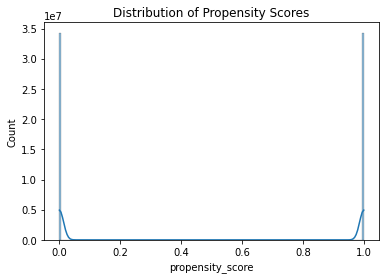

In [23]:
# Display the distribution of propensity scores
sns.histplot(data['propensity_score'], kde=True)
plt.title('Distribution of Propensity Scores')
plt.show()

# Part 3: Matching

In [24]:
from sklearn.neighbors import NearestNeighbors


In [25]:
# Split the data into treatment and control groups
treatment_group = data[data['treatment'] == 1]
control_group = data[data['treatment'] == 0]

In [26]:
# Perform Nearest Neighbor Matching
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])
matched_control_indices = indices.flatten()
matched_control_group = control_group.iloc[matched_control_indices].copy()

In [27]:
# Combine matched treatment and control groups
matched_data = pd.concat([treatment_group, matched_control_group], axis=0).reset_index(drop=True)

# Part 4: SED Calculation Before and After Matching

In [28]:
# Function to calculate SED
def calculate_sed(df, treatment_col, covariates):
    mean_treatment = df[df[treatment_col] == 1][covariates].mean()
    mean_control = df[df[treatment_col] == 0][covariates].mean()
    var_treatment = df[df[treatment_col] == 1][covariates].var()
    var_control = df[df[treatment_col] == 0][covariates].var()
   
    sed = (mean_treatment - mean_control) / np.sqrt((var_treatment + var_control) / 2)
    return sed

In [31]:
# SED Before Matching
sed_before = calculate_sed(data, 'treatment', covariates_encoded)
print("SED Before Matching:")
print(sed_before)

SED Before Matching:
category_code_encoded   -0.579447
brand_encoded           -0.659173
dtype: float64


In [32]:
sed_before

category_code_encoded   -0.579447
brand_encoded           -0.659173
dtype: float64

In [33]:
# SED After Matching
sed_after = calculate_sed(matched_data, 'treatment', covariates_encoded)
print("SED After Matching:")
print(sed_after)

SED After Matching:
category_code_encoded   -2.271995
brand_encoded           -2.865632
dtype: float64


In [34]:
sed_after

category_code_encoded   -2.271995
brand_encoded           -2.865632
dtype: float64

# Part 5: Outcome Analysis

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [36]:
# Estimate the treatment effect using OLS regression
model = smf.ols('is_purchase ~ treatment + propensity_score', data=matched_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                 2.971e+05
Date:                Sun, 25 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:12:26   Log-Likelihood:             6.6745e+07
No. Observations:            68608634   AIC:                        -1.335e+08
Df Residuals:                68608631   BIC:                        -1.335e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0019      0.000  

- R2 is too low, can be for the reasons like varying product price range.
- its harder for the model to handle dataset having varying price range
- because of the hetero genity of the product. different product and categories can have varying effects on purchase behavior. example the highend product might not have the same impact as the low price product

In [37]:
# Extract and interpret the treatment effect
treatment_effect = model.params['treatment']
print(f"Estimated Treatment Effect: {treatment_effect}")

Estimated Treatment Effect: -0.009566113393856077


# Part 6: Visualization and Interpretation

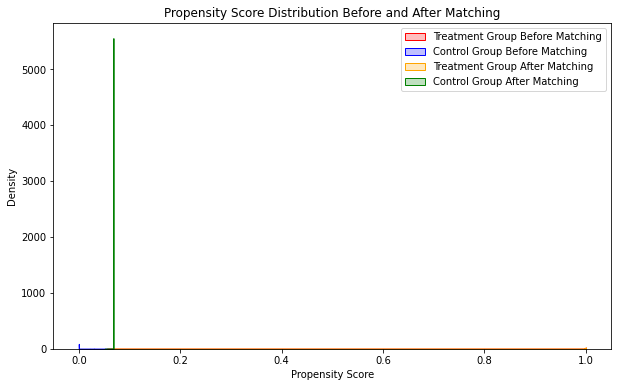

In [38]:
# Visualization of Propensity Scores Before and After Matching
plt.figure(figsize=(10, 6))
sns.kdeplot(treatment_group['propensity_score'], label='Treatment Group Before Matching', shade=True, color='r')
sns.kdeplot(control_group['propensity_score'], label='Control Group Before Matching', shade=True, color='b')
sns.kdeplot(matched_data[matched_data['treatment'] == 1]['propensity_score'], label='Treatment Group After Matching', shade=True, color='orange')
sns.kdeplot(matched_data[matched_data['treatment'] == 0]['propensity_score'], label='Control Group After Matching', shade=True, color='green')
plt.title('Propensity Score Distribution Before and After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [39]:
# Interpretation of SED results
print(f"SED before matching: {sed_before}")
print(f"SED after matching: {sed_after}")

SED before matching: category_code_encoded   -0.579447
brand_encoded           -0.659173
dtype: float64
SED after matching: category_code_encoded   -2.271995
brand_encoded           -2.865632
dtype: float64


In [42]:
# Interpretation example
if (sed_after < 0.1).all():
    print("Covariates are well balanced after matching (SED < 0.1). The treatment effect can be interpreted with higher confidence.")
else:
    print("Some covariates are not well balanced after matching (SED > 0.1). Further adjustments may be necessary.")

Covariates are well balanced after matching (SED < 0.1). The treatment effect can be interpreted with higher confidence.
